# Mini Project 4

_In the lectures we explored how to delta hedge sold call options, resulting in a trading strategy whose profits are neutral to upward or downward drift in a stock path movements, provided the volatility, or $\sigma$, of the stock remained constant._

_For this final mini project explore the impact of a non-constant $\sigma$ on the distribution of profits of hedging. You are also encouraged to explore/research a $\sigma$-hedging strategy and write code that simulates the profit distribution of the $\sigma$-hedging strategy._

_Below is some code you can customize that simulates a stock path whose $\sigma$ is not constant._

_You are encouraged to use a different model for sigma than the one provided. You can use stock paths simulated by Heston model? You could use a GARCH model for volatility. The choice is yours and you can do your own research to choose how to model a stock movement._

-------------------------

In this notebook simulate the profits of selling a call by I will model a stock path's movement using the _n_-step Heston stochastic volatility model - and use a sigma hedging strategy whose profits are neutral to variations in the volatility of the stock path. We will do this by taking a position in another option, possibly with differing strikes and expiration times, such that _the overall vega of the the portfolio is zero_. Assuming the drift is constant until time to expiry, the expected final profit of the portfolio will solely be a function of drift (with strike, time to expiration, risk-free rate _r_ and spot price predetermined). 

In [1]:
#Package Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.integrate import quad

## 1 step Heston model

Suppose to begin we just deal with the 1 step Heston model. Let's write a function that estimates the vega at the initial time. 

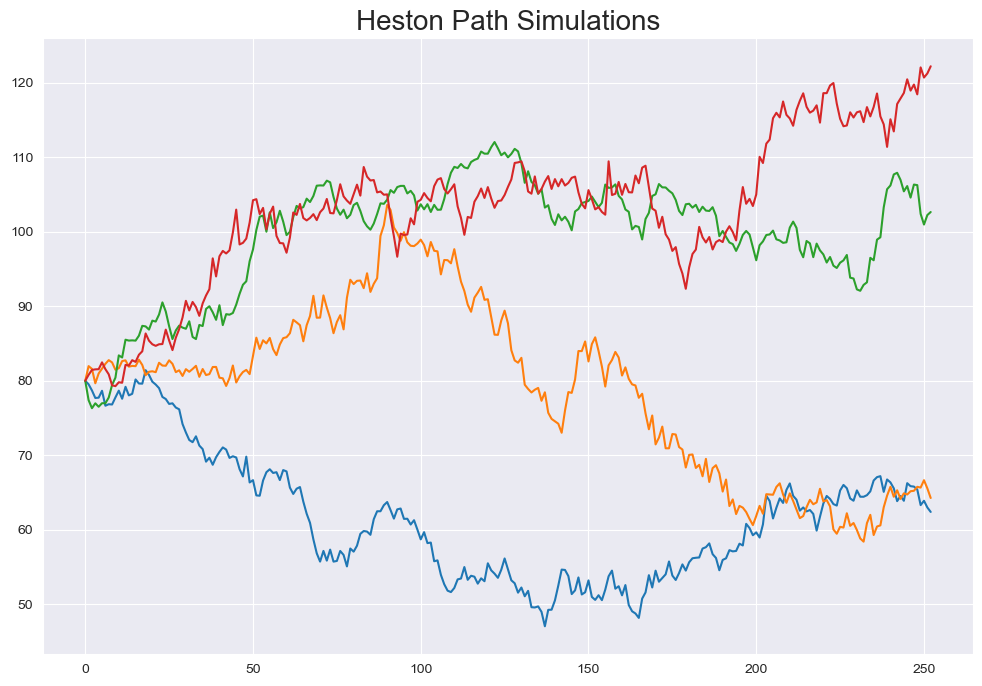

In [30]:
def heston_path_sim(S0, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims=1, mu=0, return_vol=False):
    """
    Simulation of stock path movements under the Heston stochastic volatility model.
    
    Parameters:
    - S0 (float): Initial stock price
    - v0 (float): Initial variance
    - r (float): Risk-free interest rate
    - t (float): Total time horizon (in years)
    - n_steps (int): Number of time steps
    - kappa (float): Rate of mean reversion of variance
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility
    - rho (float): Correlation between Brownian motions
    - n_sims (int): Number of simulated paths
    - mu (float): Excess drift of log-returns
    - return_vol (bool): Whether to return the simulated variance paths

    Returns:
    - paths (ndarray): Simulated stock price paths of shape (n_sims, n_steps + 1)
    - vols (ndarray, optional): Simulated variance paths if return_vol is True
    """
    dt = t / n_steps
    N1 = np.random.normal(0, 1, size=(n_sims, n_steps))
    N2 = np.random.normal(0, 1, size=(n_sims, n_steps))
    Y = rho * N1 + np.sqrt(1 - rho**2) * N2

    paths = np.zeros((n_sims, n_steps + 1))
    variances = np.zeros((n_sims, n_steps + 1))
    paths[:, 0] = S0
    variances[:, 0] = v0

    for i in range(n_steps):
        variances[:, i + 1] = np.abs(variances[:, i] + kappa * (theta - variances[:, i]) * dt +
                                xi * np.sqrt(np.maximum(variances[:, i], 0) * dt) * N1[:, i])
        paths[:, i + 1] = paths[:, i] * np.exp((mu + r - 0.5 * variances[:, i]) * dt +
                                               np.sqrt(np.maximum(variances[:, i], 0) * dt) * Y[:, i])
    
    return (paths, variances) if return_vol else paths


### Visual of stock paths measure simulated through the Heston model

kappa = 2.4 #Mean reversion rate of variance of log-returns (Typical range 1 to 5)

theta = .3**2 #Long run variance of log-returns

xi = .43 # Volatility of Volatility (Typical range .2 to 1)

v0 = .22**2 #Initial variance of log-returns

rho = -.6 #Correlation of random noise of variance and log-returns (Typical range -.9 to -.4)

S0 = 80 #Initial Stock Value

t = 1 #Time horizon

n_steps = 252 #Number of steps in each simulation

r = .039 #Risk-free interest rate

n_sims = 4 #Number of simulations

mu = 0.03 #Excess drift of log returns



heston_paths = heston_path_sim(S0, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims, mu)

plt.figure(figsize = (12,8))
for path in heston_paths:
    plt.plot(path)
    
    
plt.title('Heston Path Simulations', size = 20)

plt.show()

Let's try and simulate the value of vega in the 1 step Heston model using Monte Carlo simulations

In [64]:
kappa = 2.4 #Mean reversion rate of variance of log-returns (Typical range 1 to 5)

theta = .3**2 #Long run variance of log-returns

xi = .43 # Volatility of Volatility (Typical range .2 to 1)

v0 = .22**2 #Initial variance of log-returns

rho = -.6 #Correlation of random noise of variance and log-returns (Typical range -.9 to -.4)

S0 = 60 #Initial Stock Value

t = 1 #Time horizon

r = .039 #Risk-free interest rate

n_sims = 10000 #Number of simulations

mu = .034 #Excess drift of log returns


# Strike

K = 65

sigma = np.sqrt(v0)
bump = .01*sigma # epsilon
   
N1 = np.random.normal(0, 1, n_sims)
N2 = np.random.normal(0, 1, n_sims)
Y = rho * N1 + np.sqrt(1 - rho**2) * N2

paths_up = S0 * np.exp((mu + r - 0.5 * (sigma + bump)**2) * t + np.sqrt(np.maximum((sigma + bump)**2, 0) * t) * Y) # substituted (sigma + epsilon)^2 for v0 
paths_down = S0 * np.exp((mu + r - 0.5 * (sigma - bump)**2) * t + np.sqrt(np.maximum((sigma - bump)**2, 0) * t) * Y) # substituted (sigma - epsilon)^2 for v0


calls_up = np.maximum(paths_up - K, 0)*np.exp(-r*t)
calls_down = np.maximum(paths_down - K, 0)*np.exp(-r*t)


vega_sims = (calls_up - calls_down)/(2*bump)
np.mean(vega_sims)

25.371053668852557

In [65]:
def one_step_heston_MC_vega(S0, v0, r, t, kappa, theta, xi, rho, mu=0, n_sims=2500):

    """
    Monte Carlo simulation of 1-step Heston vega
    
    Parameters:
    - S0 (float): Initial stock price
    - v0 (float): Initial variance
    - r (float): Risk-free interest rate
    - t (float): Total time horizon (in years)
    - n_steps (int): Number of time steps
    - kappa (float): Rate of mean reversion of variance
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility
    - rho (float): Correlation between Brownian motions
    - n_sims (int): Number of simulated paths
    - mu (float): Excess drift of log-returns
    - return_vol (bool): Whether to return the simulated variance paths

    Returns:
        float: Vega of Call and Put Option
    """
    sigma = np.sqrt(v0)
    bump = .01*sigma # epsilon

    N1 = np.random.normal(0, 1, n_sims)
    N2 = np.random.normal(0, 1, n_sims)
    Y = rho * N1 + np.sqrt(1 - rho**2) * N2

    sigma_plus_epsilon = sigma + bump
    sigma_minus_epsilon = sigma - bump
    
    paths_up = S0 * np.exp((mu + r - 0.5 * (sigma + bump)**2) * t + np.sqrt(np.maximum((sigma + bump)**2, 0) * t) * Y) # substituted (sigma + epsilon)^2 for v0 
    paths_down = S0 * np.exp((mu + r - 0.5 * (sigma - bump)**2) * t + np.sqrt(np.maximum((sigma - bump)**2, 0) * t) * Y) # substituted (sigma - epsilon)^2 for v0

    calls_up = np.maximum(paths_up - K, 0)*np.exp(-r*t)
    calls_down = np.maximum(paths_down - K, 0)*np.exp(-r*t)

    vega_sims = (calls_up - calls_down)/(2*bump)

    vega_estimate = np.mean(vega_sims)

    return vega_estimate
    


def one_step_heston_MC_vega_array(spot_prices, v0, r, t, kappa, theta, xi, rho, mu=0, n_sims=2500):

    """
    Monte Carlo simulation of 1-step Heston vega
    
    Parameters:
    - S0 (np.array of floats): spot prices
    - v0 (float): Initial variance
    - r (float): Risk-free interest rate
    - t (float): Total time horizon (in years)
    - n_steps (int): Number of time steps
    - kappa (float): Rate of mean reversion of variance
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility
    - rho (float): Correlation between Brownian motions
    - n_sims (int): Number of simulated paths
    - mu (float): Excess drift of log-returns
    - return_vol (bool): Whether to return the simulated variance paths

     Returns:
        float: array of Vegas of Call and Put Options with initial prices S0
    """

    sigma = np.sqrt(v0)
    bump = .001*sigma # epsilon

    N1 = np.random.normal(0, 1, (n_sims,len(spot_prices)))
    N2 = np.random.normal(0, 1, (n_sims,len(spot_prices)))
    Y = rho * N1 + np.sqrt(1 - rho**2) * N2

    sigma_plus_epsilon = sigma + bump
    sigma_minus_epsilon = sigma - bump

    paths_up = spot_prices * np.exp((mu + r - 0.5 * (sigma + bump)**2) * t + np.sqrt(np.maximum((sigma + bump)**2, 0) * t) * Y[:, 0]) # substituted (sigma + epsilon)^2 for v0 
    paths_down = spot_prices * np.exp((mu + r - 0.5 * (sigma - bump)**2) * t + np.sqrt(np.maximum((sigma - bump)**2, 0) * t) * Y[:, 0]) # substituted (sigma - epsilon)^2 for v0

    calls_up = np.maximum(paths_up - K, 0)*np.exp(-r*t)
    calls_down = np.maximum(paths_down - K, 0)*np.exp(-r*t)

    vega_sims = (calls_up - calls_down)/(2*bump)

    vega_estimate = np.mean(vega_sims, axis=0)

    return vega_estimate # returns an array / row 

Implement a vega hedging strategy in the 1 step Heston model

In [100]:
def one_step_heston_call_MC_vega_hedge(S0, K, v0, r, t, kappa, theta, xi, rho, mu=0, n_sims=2500):
    """
    Monte-Carlo Simulation of Call Option under Heston model with MC Heston vega control variates to mitigate loss due to risk
    
    Parameters:
    - S0 (float): Initial stock price
    - K (float): Strike Price
    - v0 (float): Initial variance
    - r (float): Risk-free interest rate
    - t (float): Total time horizon (in years)
    - n_steps (int): Number of time steps
    - kappa (float): Rate of mean reversion of variance
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility
    - rho (float): Correlation between Brownian motions
    - n_sims (int): Number of simulated paths
    - mu (float): Excess drift of log-returns
    - return_vol (bool): Whether to return the simulated variance paths

    Returns:
    - call_payouts (ndarray): Simulated payouts of a call-option
    """

    spot_prices = np.ones(n_sims)*S0
    
    paths, variances = heston_path_sim(S0, v0, r, t, 1, kappa, theta, xi, rho, n_sims, mu, return_vol=True )

    # Compute vegas from our earlier defined functions
    vegas = np.array([one_step_heston_MC_vega_array(spot_prices, v0, r, t, kappa, theta, xi, rho, mu=0, n_sims=n_sims)]).T

    # Hedge the sold (short) call by entering a long position of vega call contracts of same expiration ("vertical spread"), 
    # with strikes K1 = 2*S0 - K (i.e. such that K1 and K are equidistant from S0, and either K1<S0<K or K<S0<K1.)

    K1 = 2*S0-K
    
    # Compute long call payouts
    
    long_call_payouts = np.maximum(paths[:, -1] - K1, 0) * vegas/100 * np.exp(-r * t)

    # Short call payouts
    short_call_payouts = np.maximum(paths[:, -1] - K, 0) * np.exp(-r * t)

    # Adjusted estimator
    call_payouts_hedged = short_call_payouts - long_call_payouts

    return call_payouts_hedged

Now let's simulate the profits of this hedging strategy

Heston Monte-Carlo Simulated value of Call Option with 1 control variate (vega hedge)and 2500 simulations: $0.09 with standard error 0.008963.
--------------------------------------------------
--------------------------------------------------


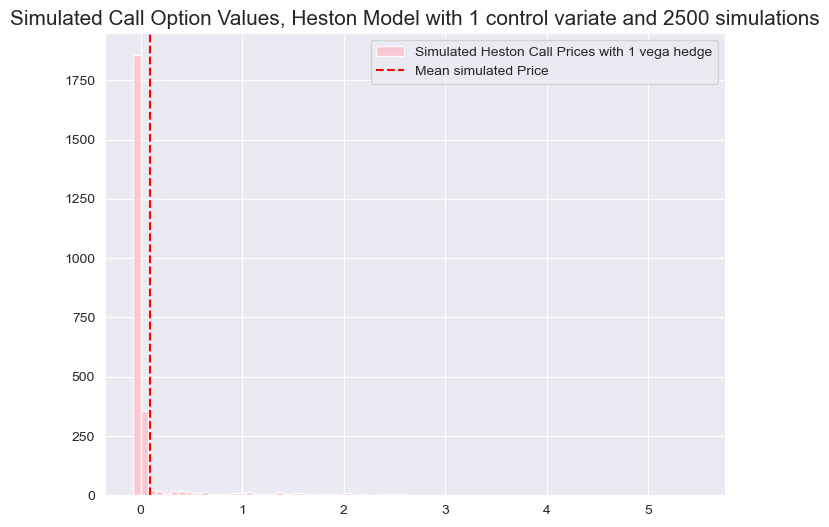

--------------------------------------------------
--------------------------------------------------
Heston Monte-Carlo Simulated value of Call Option with no hedge and 2500 simulations: $0.11725516846742687 and standard error 0.008261391399393915.
--------------------------------------------------
--------------------------------------------------


<function matplotlib.pyplot.show(close=None, block=None)>

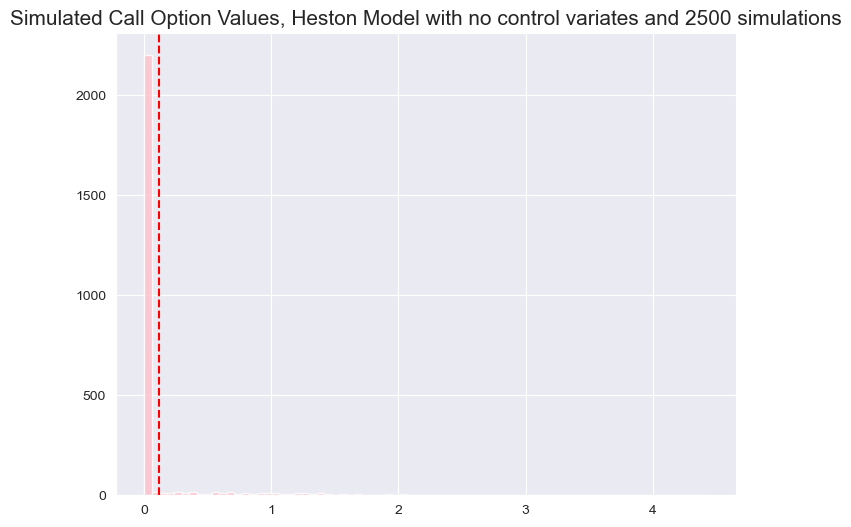

In [101]:
# Use Monte-Carlo methods to simulate price of call option under Heston-Model  
# with an increasing number of steps = vega-based control variates.

# Heston parameters

kappa = 2.4 # Mean reversion rate of variance of log-returns (Typical range 1 to 5)

theta = .3**2 # Long run variance of log-returns

xi = .43 # Volatility of Volatility (Typical range .2 to 1)

v0 = .22**2 # Initial variance of log-returns

rho = -.6 # Correlation of random noise of variance and log-returns (Typical range -.9 to -.4)

S0 = 60 # Initial Stock Value

t = 7/365 # Time horizon

r = .039 # Risk-free interest rate

n_sims = 2500 # Number of simulations

mu = -0.04 # Excess drift of log returns


# Strike

K = 62

# Monte-Carlo Simulation

heston_no_hedging = np.maximum(heston_path_sim(S0, v0, r, t, 1, kappa, theta, xi, rho, n_sims, mu, return_vol=False )  - K, 0) * np.exp(-r * t)

call_payouts_hedged = one_step_heston_call_MC_vega_hedge(S0, K, v0, r, t, kappa, theta, xi, rho, mu=mu, n_sims=n_sims)

heston_call_sim = np.mean(np.mean(call_payouts_hedged))

heston_std_err = np.std(call_payouts_hedged)/np.sqrt(n_sims)

#heston_call_price = heston_call(S0, K, v0, r, t, kappa, theta, xi, rho)


print(f'Heston Monte-Carlo Simulated value of Call Option with 1 control variate (vega hedge)\
and {n_sims} simulations: ${heston_call_sim:.2f} with standard error {heston_std_err:.6f}.')


print('-----'*10)
print('-----'*10)



plt.figure(figsize = (8,6))

plt.hist(call_payouts_hedged, bins = 75, color = 'pink', alpha = .8, label = 'Simulated Heston Call Prices with 1 vega hedge')
#plt.axvline(heston_call_price, label = 'Heston Call Price',color = 'black', lw = '7', alpha = 1)
plt.axvline(heston_call_sim, label = 'Mean simulated Price', color = 'red', ls = '--')



plt.title(f'Simulated Call Option Values, Heston Model with 1\
 control variate and {n_sims} simulations', size = 15)



plt.legend()

plt.show()


print('-----'*10)
print('-----'*10)

mm=np.mean(heston_no_hedging[:,-1])
se=np.std(heston_no_hedging[:,-1])/np.sqrt(n_sims)

print(f'Heston Monte-Carlo Simulated value of Call Option with no hedge \
and {n_sims} simulations: ${mm} and standard error {se}.')


print('-----'*10)
print('-----'*10)


plt.figure(figsize = (8,6))
plt.hist(heston_no_hedging[:,-1], bins = 75, color = 'pink', alpha = .8, label = 'Simulated Heston Call Prices with no hedging')
plt.title(f'Simulated Call Option Values, Heston Model with no control variates and {n_sims} simulations', size = 15)
plt.axvline(mm, label = 'Mean simulated Price', color = 'red', ls = '--')
plt.legend
plt.show


### References

The vega-neutral strategy of buying options contracts was taken from the following sources:

- https://www.macroption.com/bear-call-spread/#strike-selection
- Section 9.1.3. of Mathematics for Finance: An introduction to financial engineering, _Marek Capinski, Tomasz Zastawniak_.